# ***Prediction en utilisant XGBOOST***

In [ ]:
# pip install datetime

In [ ]:
# pip install tqdm

In [ ]:
# pip install yfinance

In [ ]:
# pip install --upgrade keras

In [ ]:
# pip install tensorflow

**Importation des packages necessaires**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta,datetime
from tqdm import tqdm
import xgboost as xgb
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
plt.style.use("dark_background")

In [36]:
end_date = (datetime.today()+timedelta(days=+1)).strftime("%Y-%m-%d")
start_date = (datetime.today()-timedelta(days=15)).strftime("%Y-%m-%d")
tickers = ["AMZN"]

In [38]:
data = yf.download(tickers=tickers ,start = start_date ,end=end_date ,interval="5m")
data # Affichage de toute la base de donnes a l'exception de la derniére ligne

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-01 09:30:00-05:00,176.889999,177.089996,176.399994,176.419998,176.419998,1366072
2024-03-01 09:35:00-05:00,176.410004,176.589996,176.070007,176.580002,176.580002,473984
2024-03-01 09:40:00-05:00,176.593704,176.949997,176.380005,176.720001,176.720001,357165
2024-03-01 09:45:00-05:00,176.699997,176.820007,176.226395,176.630005,176.630005,291931
2024-03-01 09:50:00-05:00,176.639999,176.839996,176.500000,176.619995,176.619995,295601
...,...,...,...,...,...,...
2024-03-15 15:35:00-04:00,174.960007,175.130005,174.949997,174.975006,174.975006,185351
2024-03-15 15:40:00-04:00,174.975006,175.038696,174.809998,174.925003,174.925003,221137
2024-03-15 15:45:00-04:00,174.925003,175.059998,174.835007,175.035004,175.035004,259005


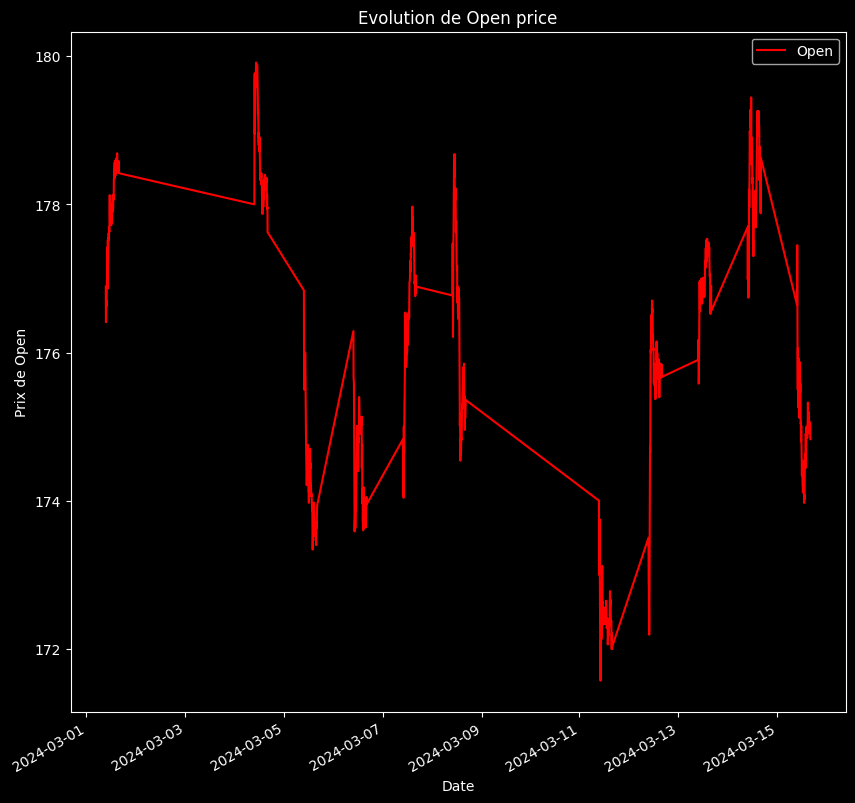

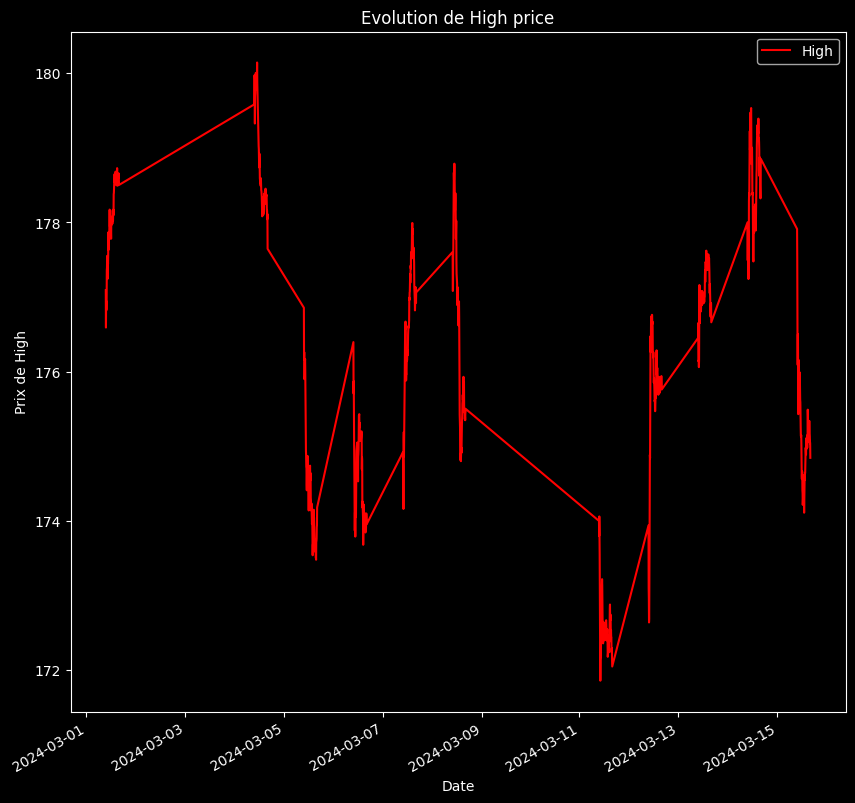

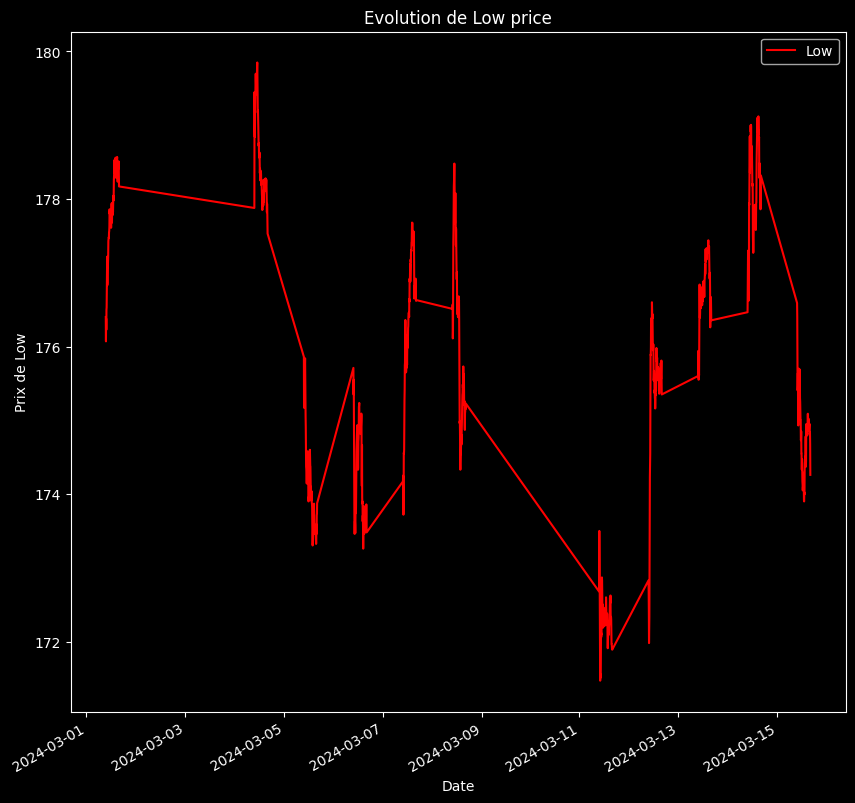

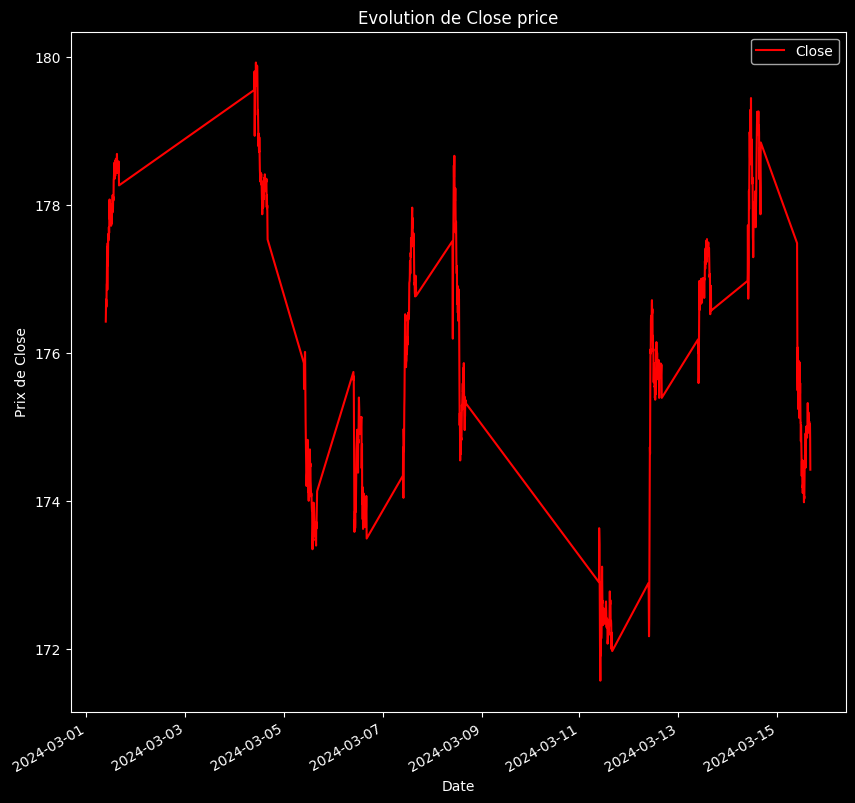

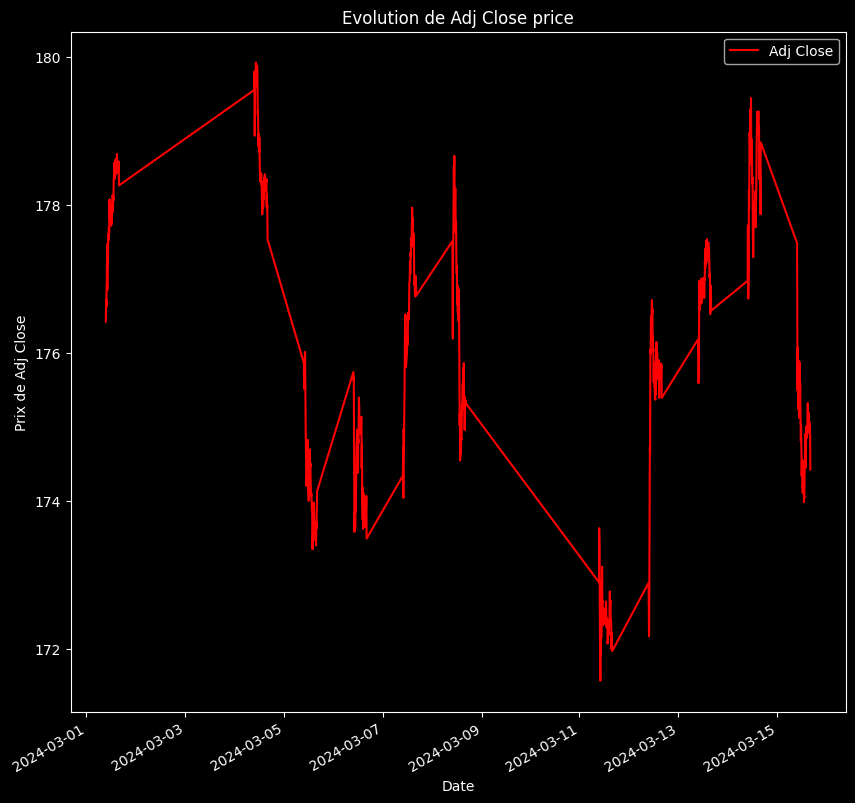

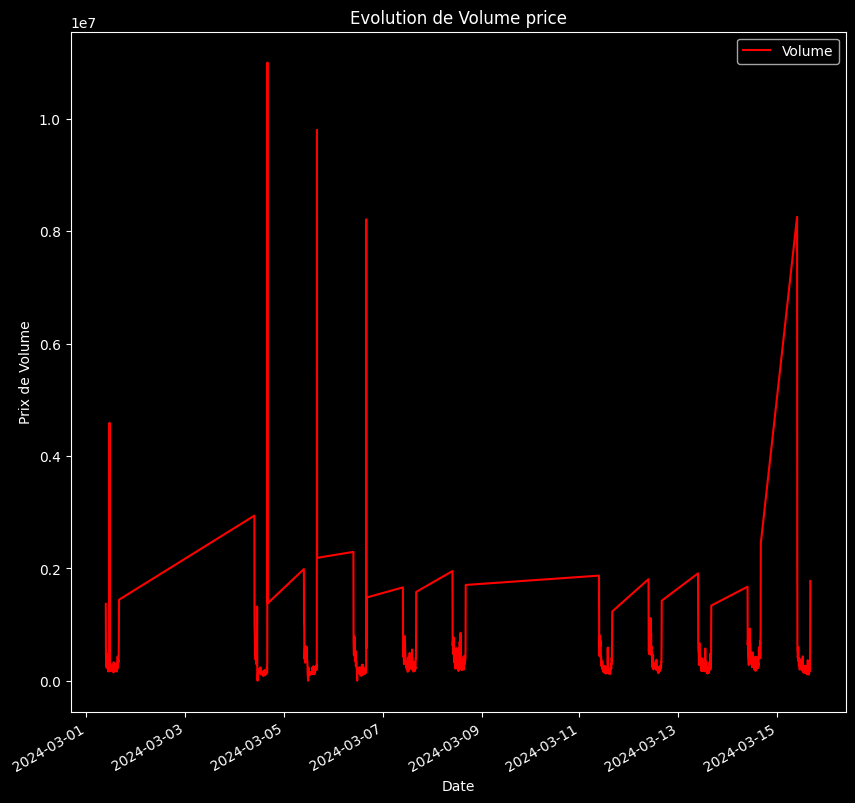

In [39]:
# Affichage des graphs pour toutes les colonnes 
for i in data:
    plt.figure(figsize=(10,10))
    data[i].plot(legend=i , color='red')
    plt.title(f"Evolution de {i} price")
    plt.ylabel(f"Prix de {i}")
    plt.xlabel("Date")
    plt.show()

In [40]:
# Creation de la fonction qui permet de creer les caracteristiques de la data set
def create_df(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek # Lundi est 1 , mardi 2 ....
    df['dayofyear'] = df.index.dayofyear # Premier jours est 1 , apres 2 est 2 jsuqu'au arrive au dernier jour ouverable
    df['weekofyear'] = df.index.isocalendar().week # 1ere semaine est 1 ...
    return df

# Application de cette methode à notre base de données
df = create_df(data)
df.head(-1)

,Open,High,Low,Close,Adj Close,Volume,hour,day,month,year,dayofweek,dayofyear,weekofyear
Datetime,,,,,,,,,,,,,
2024-03-01 09:30:00-05:00,176.889999,177.089996,176.399994,176.419998,176.419998,1366072,9,1,3,2024,4,61,9
2024-03-01 09:35:00-05:00,176.410004,176.589996,176.070007,176.580002,176.580002,473984,9,1,3,2024,4,61,9
2024-03-01 09:40:00-05:00,176.593704,176.949997,176.380005,176.720001,176.720001,357165,9,1,3,2024,4,61,9
2024-03-01 09:45:00-05:00,176.699997,176.820007,176.226395,176.630005,176.630005,291931,9,1,3,2024,4,61,9
2024-03-01 09:50:00-05:00,176.639999,176.839996,176.500000,176.619995,176.619995,295601,9,1,3,2024,4,61,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 15:30:00-04:00,175.070007,175.169998,174.940094,174.979996,174.979996,163285,15,15,3,2024,4,75,11
2024-03-15 15:35:00-04:00,174.960007,175.130005,174.949997,174.975006,174.975006,185351,15,15,3,2024,4,75,11
2024-03-15 15:40:00-04:00,174.975006,175.038696,174.809998,174.925003,174.925003,221137,15,15,3,2024,4,75,11


<Axes: >

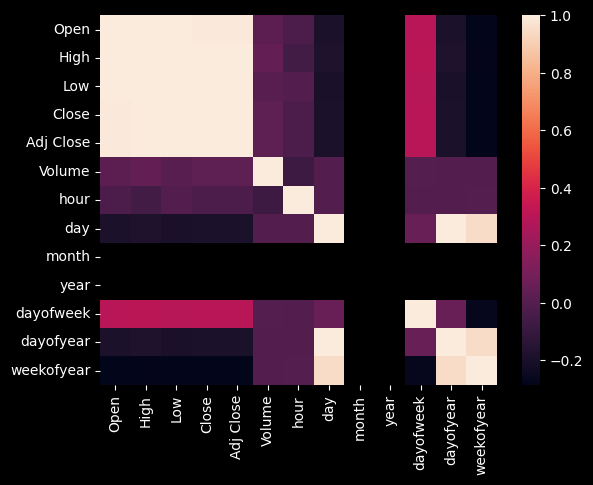

In [41]:
# Affichage de la matrice de correlation a l'aide de module seaborn
corr = df.corr() #Matrice de correlation
sns.heatmap(corr) # Affichage de cette matrice 

In [42]:
close = df['Close']  # Utiliser la colonne Close

# Création des fenêtres et des cibles
windows = []
target = []
length = 240

for i in range(len(close)-length):
    x = close.iloc[i:i+length].values
    y = close.iloc[i+length]
    windows.append(x)
    target.append(y)

windows = np.array(windows)
target = np.array(target).reshape(-1, 1)

# Normalisation des données
scaler = MinMaxScaler()
windows_norm = scaler.fit_transform(windows)
target_norm = scaler.fit_transform(target)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(windows_norm, target_norm, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

MSE: 0.001304939233151802


MSE: 0.001304939233151802


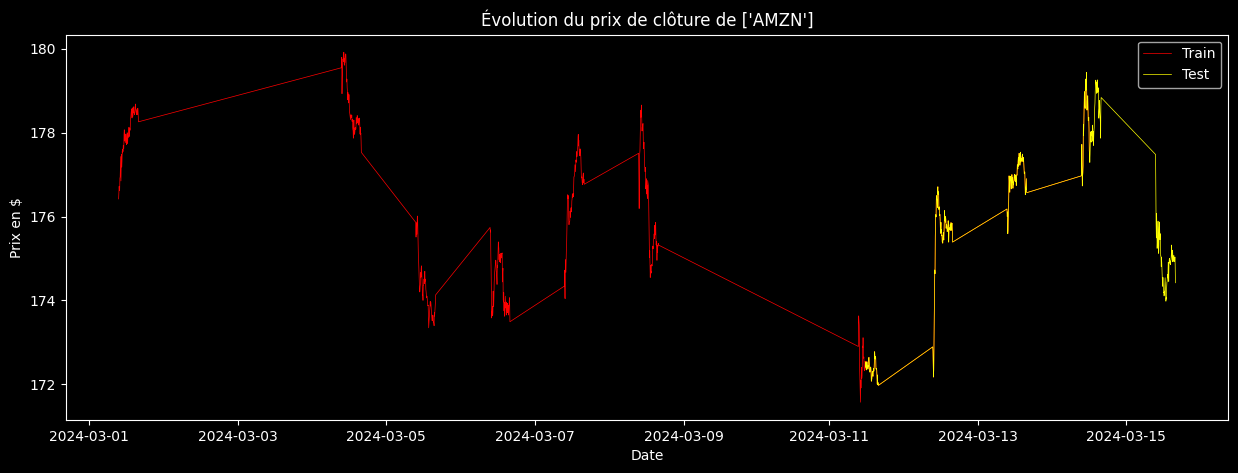

In [43]:
# Sélection de la colonne close pour la prédiction
close = df['Close']  # Utilisation d'un accès plus explicite à la colonne

windows = []
target = []
length = 240
for i in range(len(close)-length):
    x = close.iloc[i:i+length].to_numpy()  # Convertir en numpy array pour faciliter le reshape
    y = close.iloc[i+length]
    windows.append(x)
    target.append([y])  # Encapsuler 'y' dans une liste pour garder la dimension
    
windows = np.array(windows)
target = np.array(target)

# Normalisation des données
scaler = MinMaxScaler()


windows_norm = scaler.fit_transform(windows)
target_norm = scaler.fit_transform(target)

#splitting
split = int(0.8*len(windows_norm)) # On prend 80% pour training set et 20% pour le test
# Splitting des données
X_train, X_test, y_train, y_test = train_test_split(windows_norm, target_norm, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calcul de l'index de séparation pour les données originales
original_split_index = split + length

plt.figure(figsize=(15,5))
# Le train couvre de 0 à original_split_index, mais pour visualiser correctement, on doit ajuster à original_split_index-length
plt.plot(df['Close'][:original_split_index], label='Train', linewidth=0.5, color="red") # Partie entrainement
# Le test commence là où le train s'arrête
plt.plot(df.index[original_split_index-length:], df['Close'][original_split_index-length:], label='Test', linewidth=0.5, color='yellow') # Partie test
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prix en $')
plt.title(f'Évolution du prix de clôture de {tickers}')
plt.show()

[0]	validation_0-rmse:0.16633


[1]	validation_0-rmse:0.11799
[2]	validation_0-rmse:0.08624


c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:0.06400
[4]	validation_0-rmse:0.05043
[5]	validation_0-rmse:0.04248
[6]	validation_0-rmse:0.03802
[7]	validation_0-rmse:0.03583
[8]	validation_0-rmse:0.03514
[9]	validation_0-rmse:0.03520
[10]	validation_0-rmse:0.03522
[11]	validation_0-rmse:0.03548
[12]	validation_0-rmse:0.03555
[13]	validation_0-rmse:0.03561
[14]	validation_0-rmse:0.03574
[15]	validation_0-rmse:0.03583
[16]	validation_0-rmse:0.03592
[17]	validation_0-rmse:0.03594
[18]	validation_0-rmse:0.03594
[19]	validation_0-rmse:0.03600
[20]	validation_0-rmse:0.03603
[21]	validation_0-rmse:0.03604
[22]	validation_0-rmse:0.03607
[23]	validation_0-rmse:0.03604
[24]	validation_0-rmse:0.03600
[25]	validation_0-rmse:0.03601
[26]	validation_0-rmse:0.03596
[27]	validation_0-rmse:0.03592
[28]	validation_0-rmse:0.03593
[29]	validation_0-rmse:0.03596
[30]	validation_0-rmse:0.03598
[31]	validation_0-rmse:0.03595
[32]	validation_0-rmse:0.03599
[33]	validation_0-rmse:0.03599
[34]	validation_0-rmse:0.03600
[35]	validation

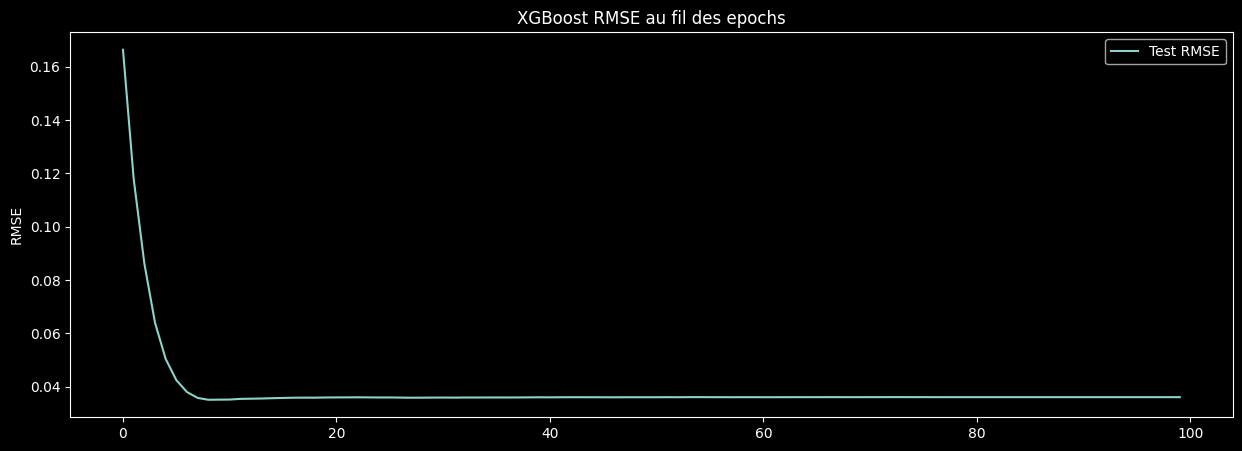

In [44]:
# Définition de l'ensemble d'évaluation avec les données de test (ou d'entraînement, selon le besoin)
eval_set = [(X_test, y_test)]

# Entraînement du modèle avec suivi de la perte sur l'ensemble de test
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

# Extraction de l'historique de la perte (RMSE ici)
# 'validation_0' représente le premier ensemble passé à eval_set, qui est ici l'ensemble de test
# Si vous aviez passé l'ensemble d'entraînement à eval_set, cela serait 'validation_0' pour celui-ci
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Présentation de la perte
plt.figure(figsize=(15,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE au fil des epochs')
plt.show()

MSE: 0.001304939233151802


C:\Users\BUNICE\AppData\Local\Temp\ipykernel_3256\3870601909.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_wind[-1] = current_prediction


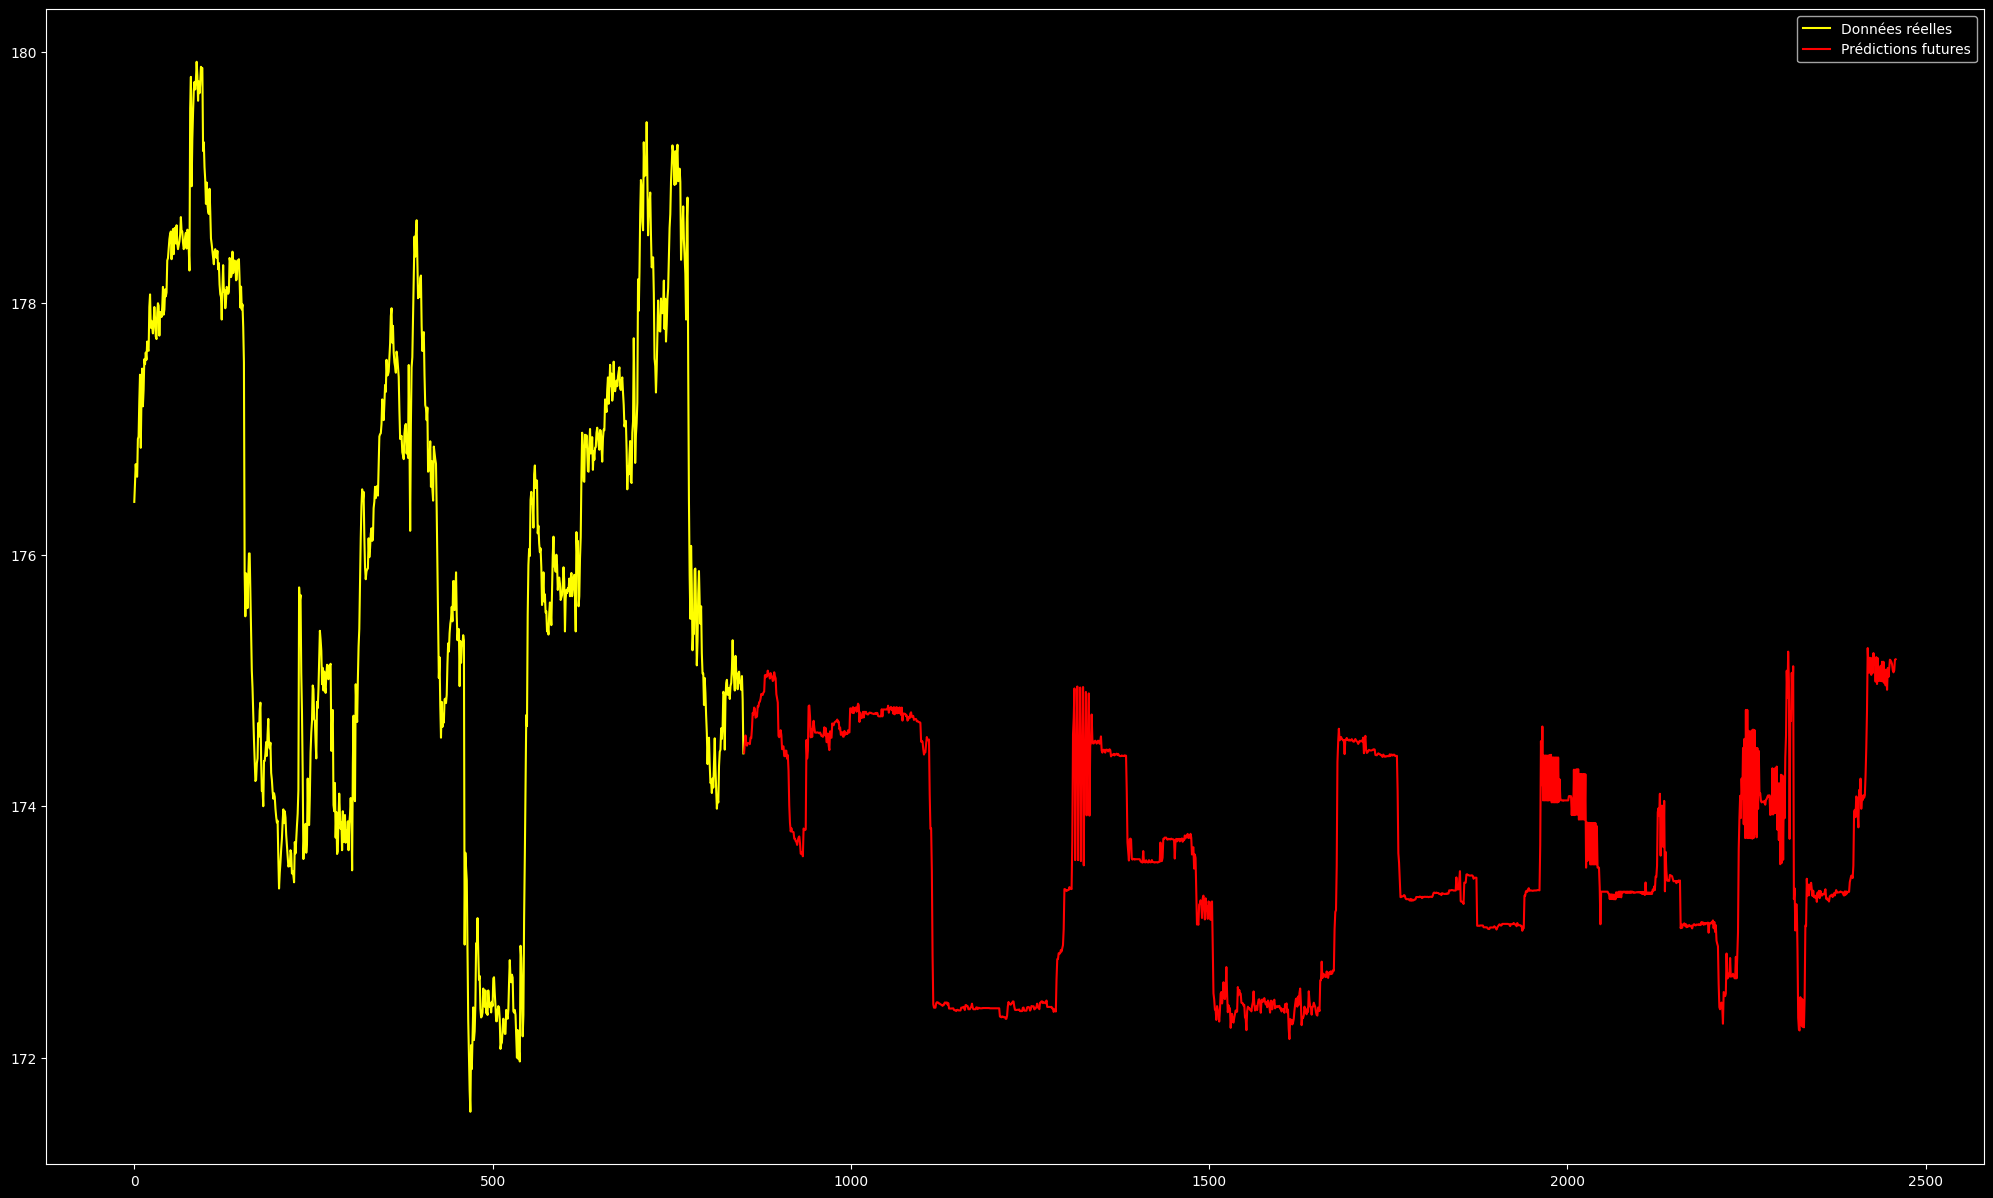

In [45]:
close = df['Close']  # Utiliser la colonne Close

# Création des fenêtres et des cibles
windows = []
target = []
length = 240

for i in range(len(close)-length):
    x = close.iloc[i:i+length].values
    y = close.iloc[i+length]
    windows.append(x)
    target.append(y)

windows = np.array(windows)
target = np.array(target).reshape(-1, 1)

# Normalisation des données
scaler = MinMaxScaler()
windows_norm = scaler.fit_transform(windows)
target_norm = scaler.fit_transform(target)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(windows_norm, target_norm, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Prédiction itérative
d1 = datetime.strptime('2024/03/07', "%Y/%m/%d")
d2 = datetime.strptime('2024/03/14', "%Y/%m/%d")
delta = d2 - d1
steps_in_future = delta.days * 24  # Exemple simplifié

f_wind = windows_norm[-1]
new_predictions = []

for i in range(steps_in_future):
    # La logique doit être ajustée pour utiliser XGBoost, pas besoin de remodeler comme pour LSTM
    current_prediction = model.predict(f_wind.reshape(1, -1))
    new_predictions.append(current_prediction[0])
    # Mettre à jour la fenêtre pour la prochaine prédiction
    f_wind = np.roll(f_wind, -1)
    f_wind[-1] = current_prediction

# Affichage des résultats
plt.figure(figsize=(25,15))
plt.plot(np.arange(len(close)), close, label='Données réelles', color='yellow')
plt.plot(np.arange(len(close), len(close)+len(new_predictions)), scaler.inverse_transform(np.array(new_predictions).reshape(-1,1)), label='Prédictions futures', color='red')
plt.legend()
plt.show()

c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


MSE: 8.199603454852807e-05


C:\Users\BUNICE\AppData\Local\Temp\ipykernel_3256\895700294.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_wind[-1] = current_prediction


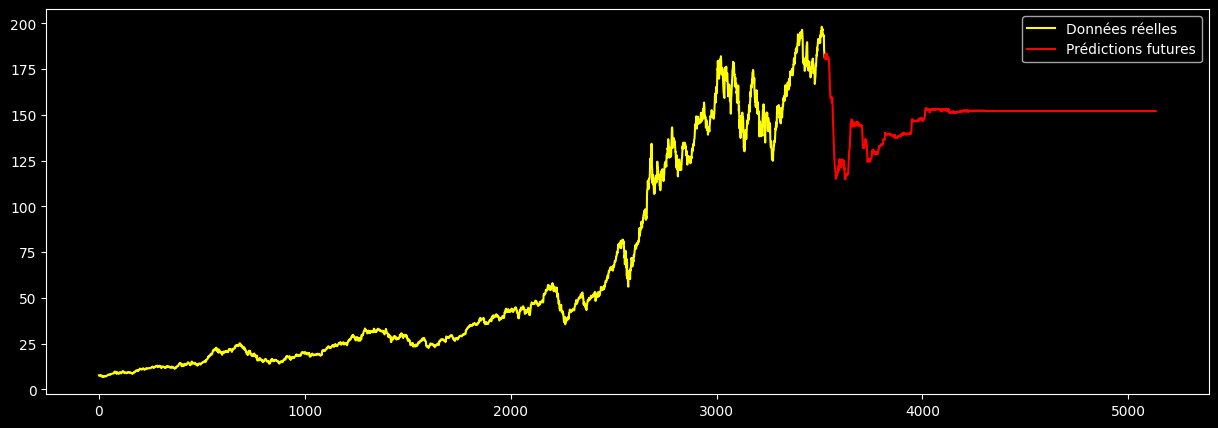

In [63]:
# Téléchargement des données
end_date = (datetime.today()-timedelta(days=2)).strftime("%Y-%m-%d")
start_date = (datetime.today()-timedelta(days=15)).strftime("%Y-%m-%d")
tickers = ["AMZN"]

data = yf.download(tickers, start=start_date, end=end_date)

# Fonction pour créer des caractéristiques à partir des dates
def create_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(data)
close = df['Close']  # Utiliser la colonne Close

# Création des fenêtres et des cibles
windows = []
target = []
length = 240

for i in range(len(close)-length):
    x = close.iloc[i:i+length].values
    y = close.iloc[i+length]
    windows.append(x)
    target.append(y)

windows = np.array(windows)
target = np.array(target).reshape(-1, 1)

# Normalisation des données
scaler = MinMaxScaler()
windows_norm = scaler.fit_transform(windows)
target_norm = scaler.fit_transform(target)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(windows_norm, target_norm, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Prédiction itérative
d1 = datetime.strptime('2024/01/07', "%Y/%m/%d")
d2 = datetime.strptime('2024/03/14', "%Y/%m/%d")
delta = d2 - d1
steps_in_future = delta.days * 24  # Exemple simplifié

f_wind = windows_norm[-1]
new_predictions = []

for i in range(steps_in_future):
    # La logique doit être ajustée pour utiliser XGBoost, pas besoin de remodeler comme pour LSTM
    current_prediction = model.predict(f_wind.reshape(1, -1))
    new_predictions.append(current_prediction[0])
    # Mettre à jour la fenêtre pour la prochaine prédiction
    f_wind = np.roll(f_wind, -1)
    f_wind[-1] = current_prediction

# Affichage des résultats
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(close)), close, label='Données réelles', color='yellow')
plt.plot(np.arange(len(close), len(close)+len(new_predictions)), scaler.inverse_transform(np.array(new_predictions).reshape(-1,1)), label='Prédictions futures', color='red')
plt.legend()
plt.show()

# ***LSTM***

In [46]:
mM = MinMaxScaler() # Creation d'un objet de l'instance MinMaxSclaer

windows_nor = mM.fit_transform(windows) # Windows normalise
target_nor = mM.fit_transform(target) # Traget normalise 

windows_nor = windows_nor.reshape((len(windows_nor) , length , 1)) 

In [47]:
# Spliiting la abse de donnes 

split = int(0.8*len(windows_nor)) # On prend que 80% de windows pour l'entrainment et 20% pour le test

X_train_1 = windows_nor[:split,:,:]
X_test_1 = windows_nor[split:,:,:]
y_train_1 = target_nor[:split,:]
y_test_1 = target_nor[split:,:]
print(X_train_1.shape,y_train_1.shape)

(488, 240, 1) (488, 1)


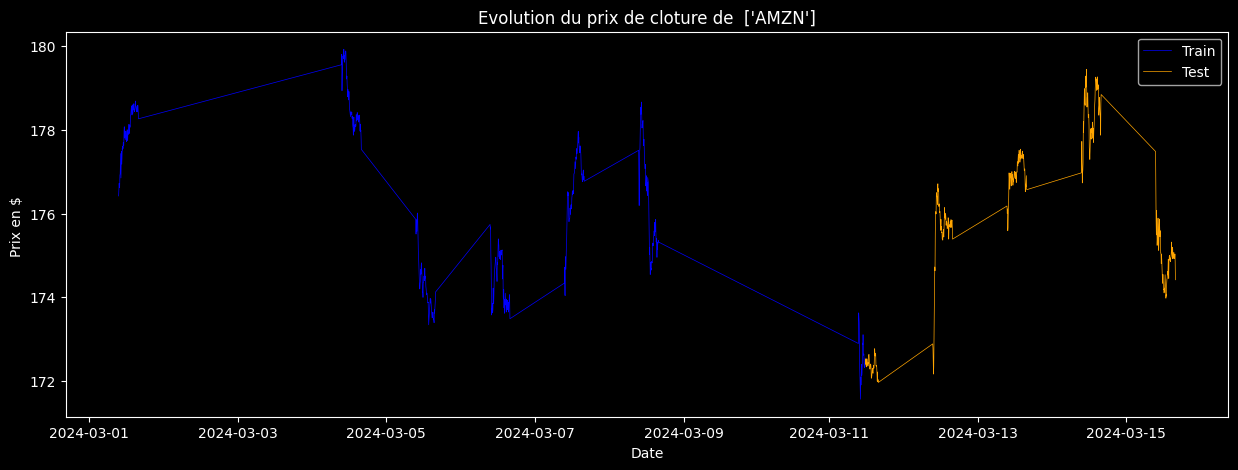

In [48]:
# Presentation des reultats avant l'application du model 
plt.figure(figsize=(15,5))
plt.plot(df['Close'][:split],label='Train',linewidth=0.5,color="blue") # Partie entrainement
plt.plot(df['Close'][split:],label='Test',linewidth=0.5,color="orange") # Partie test 
plt.legend()
plt.xlabel('Date')
plt.ylabel('Prix en $ ')
plt.title(f'Evolution du prix de cloture de  {tickers}')
plt.show()

In [49]:
model_1 = Sequential()
model_1.add(LSTM(100,input_shape=(X_train_1.shape[1],X_train_1.shape[2])))
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='linear'))
model_1.compile(optimizer='adam', loss='mse')
model_1.summary()

c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model_1.fit(X_train_1,y_train_1, epochs=5, batch_size=100, verbose=1)

Epoch 1/5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.1553
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - loss: 0.0191
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0129
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.0132
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0117


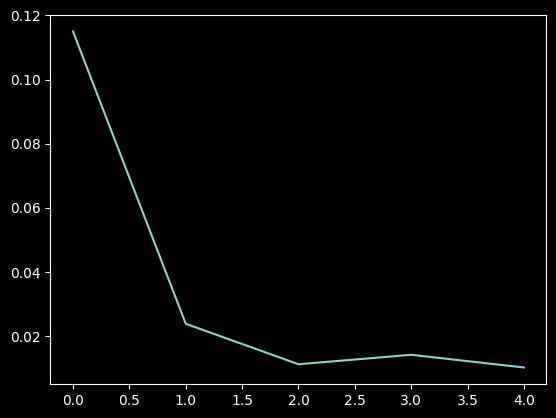

In [51]:
plt.plot(model_1.history.history['loss'] )

In [52]:
pred_sc = model_1.predict(X_test_1)
pred = mM.inverse_transform(pred_sc)
y_test_ic = mM.inverse_transform(y_test_1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


The Coefficient of determination (R-squared) = 0.8384


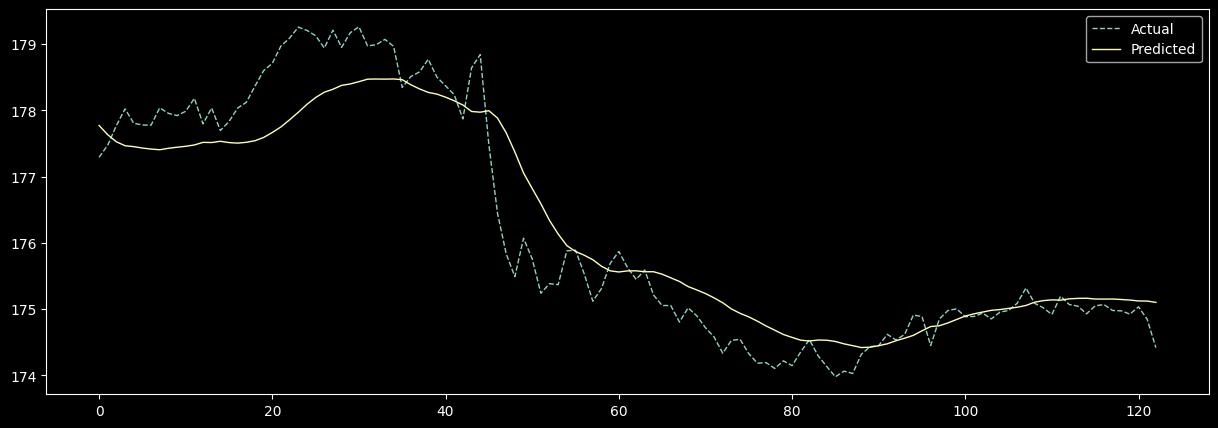

In [53]:
print('The Coefficient of determination (R-squared) = {:.4f}'.format(r2_score(pred,y_test_ic)))

plt.figure(figsize=(15,5))
plt.plot(y_test_ic,'--',label='Actual',linewidth=1)
plt.plot(pred,label='Predicted',linewidth=1)
plt.legend()

In [54]:
#training on entire dataset
X = windows_nor
y = target_nor

model_1.fit(X,y, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.0075
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0073
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0072
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0064
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0062


In [58]:
str_d1 = '2024/03/16'
str_d2 = '2024/03/18'

# convert string to date object
d1 = datetime.strptime(str_d1, "%Y/%m/%d")
d2 = datetime.strptime(str_d2, "%Y/%m/%d")

delta = d2-d1
steps_in_future = delta.days * 24
f_wind = windows_nor[-1]
f_tar=target_nor[-1]
new_predictions = []

#for i in range(steps_in_future):

#    current_prediction = model_1.predict(f_wind)
#    new_predictions.append(current_prediction[0])
#    # Mettre à jour la fenêtre pour la prochaine prédiction
#    f_wind = np.roll(f_wind, -1)
#    f_wind[-1] = current_prediction

for i in range(steps_in_future):

    current_prediction = np.append(f_wind[1:],[f_tar]).reshape(-1,1)
    next_pred = model_1.predict(current_prediction.reshape(1,length,1))
    new_predictions.append(next_pred[0][0])
    # Mettre à jour la fenêtre pour la prochaine prédiction
    f_wind = current_prediction
    f_wind[-1] = next_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [59]:
new = mM.inverse_transform(np.array(new_predictions).reshape(-1,1))

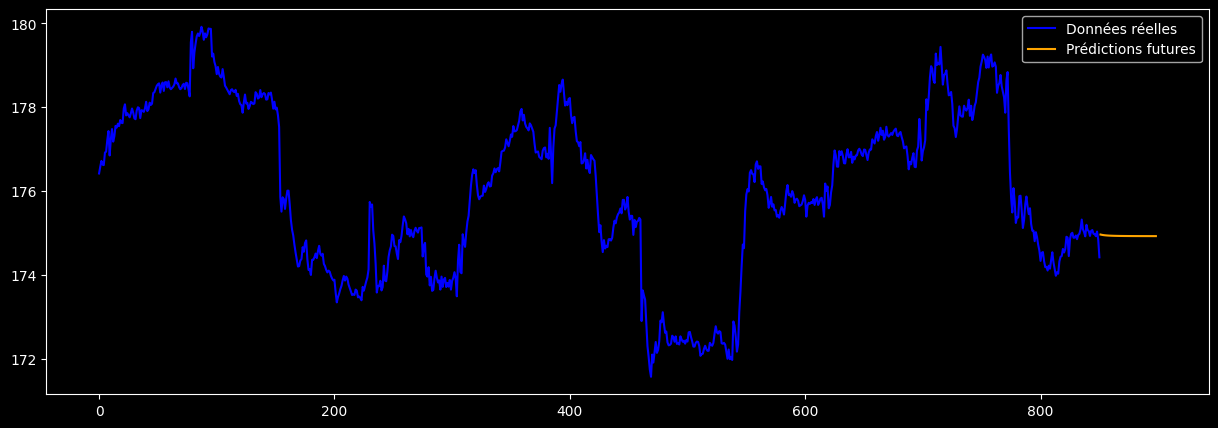

In [61]:
# Affichage des résultats
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(close)), close, label='Données réelles', color='blue')
plt.plot(np.arange(len(close), len(close)+len(new_predictions)), scaler.inverse_transform(np.array(new_predictions).reshape(-1,1)), label='Prédictions futures', color='orange')
plt.legend()
plt.show()

# ***Series Temporelles***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance as yf

C:\Users\BUNICE\AppData\Local\Temp\ipykernel_15624\2593134768.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[*********************100%%**********************]  1 of 1 completed
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will 

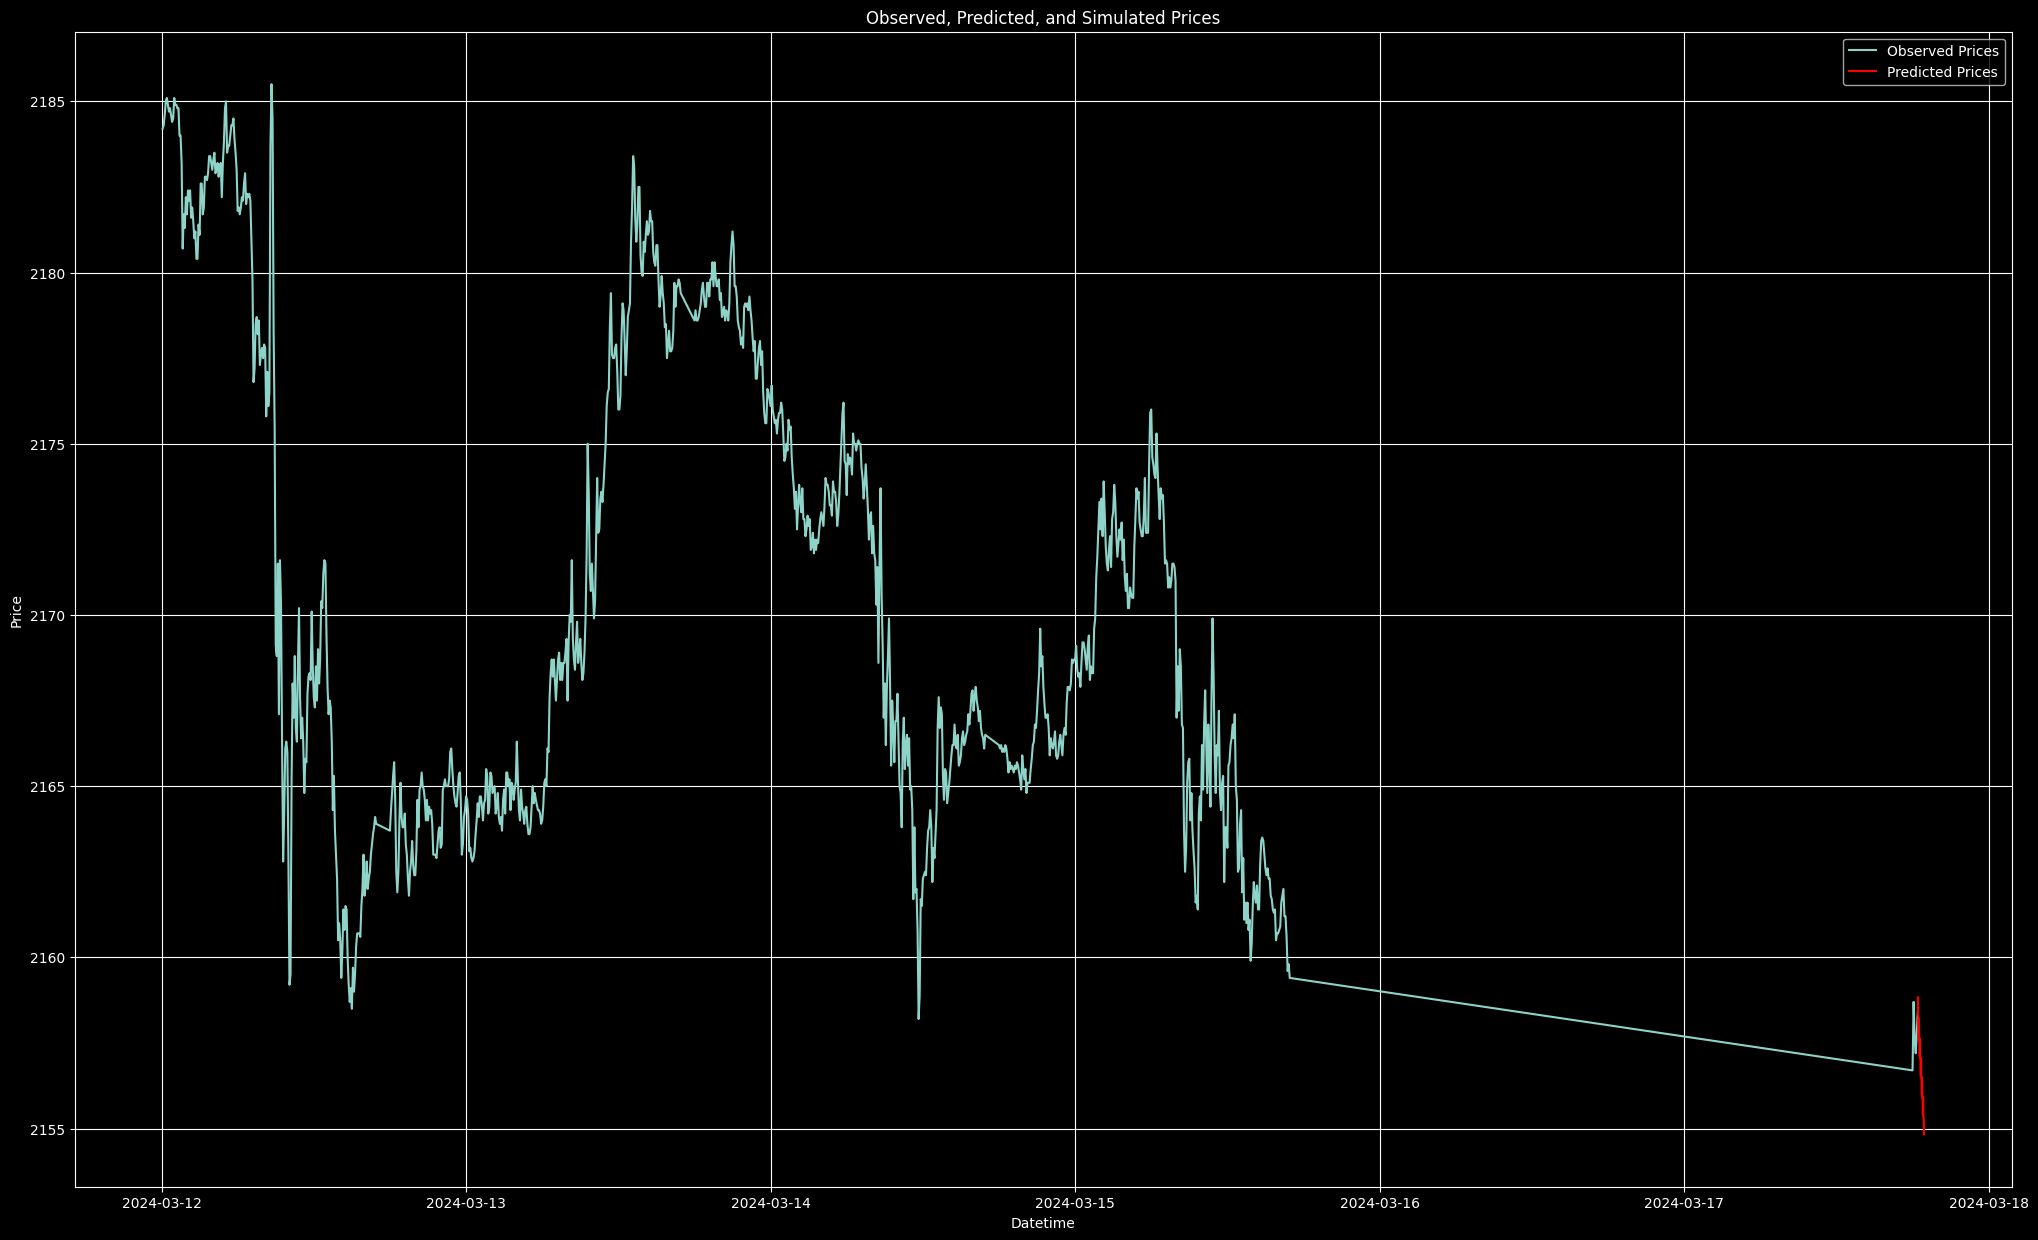

In [11]:
# Télécharger les données de prix d'une action à partir de Yahoo Finance
symbol = 'GC=F'  
end_date = (datetime.today()+timedelta(days=1)).strftime("%Y-%m-%d")
start_date = (datetime.today()-timedelta(days=5)).strftime("%Y-%m-%d")
data = yf.download(symbol, start=start_date, end=end_date, interval='5m')

# Calculer les rendements de minute en minute
data['Return'] = data['Close'].pct_change()

# Supprimer les valeurs manquantes
data = data.dropna()

# Ajuster un modèle SARIMA aux rendements
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 5)  # L'ordre saisonnier exact peut varier
sarima_model = SARIMAX(data['Return'], order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# Prédire les rendements pour les 30 prochaines minutes
forecast_steps = 30
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data.index[-1], periods=forecast_steps, freq='T')
forecast_values = forecast.predicted_mean

# Prédire les prix en utilisant les rendements prédits
predicted_prices = []
last_price = data['Close'].iloc[-1]
for return_forecast in forecast_values:
    predicted_price = last_price * (1 + return_forecast)
    predicted_prices.append(predicted_price)
    last_price = predicted_price

# Simuler les prix en utilisant la méthode de Monte Carlo
n_simulations = 10000
simulated_trajectories = []
mean_return = data['Return'].mean()
std_return = data['Return'].std()

for _ in range(n_simulations):
    simulated_returns = np.random.normal(mean_return, std_return, forecast_steps)
    simulated_prices = [data['Close'].iloc[-1]]  # Initialiser avec le dernier prix connu
    for sim_return in simulated_returns:
        simulated_price = simulated_prices[-1] * (1 + sim_return)
        simulated_prices.append(simulated_price)
    simulated_trajectories.append(simulated_prices)

# Tracer les prix observés, prédits et simulés
plt.figure(figsize=(25, 15))
plt.plot(data.index, data['Close'], label='Observed Prices')
plt.plot(forecast_index, predicted_prices, color='red', label='Predicted Prices')
# Ajoutez ici le code pour tracer les trajectoires simulées si nécessaire
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Observed, Predicted, and Simulated Prices')
plt.legend()
plt.grid(True)
plt.show()
